<a href="https://colab.research.google.com/github/jjjohn1994/Classification_On_Iris/blob/master/GenerativeAdversarialNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


In [0]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

/device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
## define a function for the generator:
def make_generator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    
  model.add(
    tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
  return model

## define a function for discriminator:
def make_discriminator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))

  model.add(
      tf.keras.layers.Dense(
          units=num_output_units, activation=None))
  return model

In [0]:
# Initialize two networks
# MNIST dataset - 28 x 28 pixels, size of input vector, z, to be 20
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  2000      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [0]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  78500     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Defining the training dataset
mnist_bldr = tfds.builder("mnist")
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image * 2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

In [0]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape: ', input_z.shape)
print('input-real -- shape: ', input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape:  (32, 784)


In [0]:
# Feed batch of input, z, vectors to the generator and get its output
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [0]:
# Batch of fake examples fed to the discriminator model to get the logits for
# batch of fake examples  - d_logits_fake
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


In [0]:
# BinaryCrossEntropy to calculate loss for generator & discriminator associated with batches 
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
## Loss for the Generator
g_labels_real =tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

Generator Loss: 0.7355


In [0]:
## Loss for the Discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real, 
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'
        .format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6583


In [0]:
import time
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.40 min | Avg Losses >> G/D 2.8645/0.2895 [D-Real: 0.0334 D-Fake: 0.2561]
Epoch 002 | ET 0.81 min | Avg Losses >> G/D 5.1811/0.3472 [D-Real: 0.1147 D-Fake: 0.2324]
Epoch 003 | ET 1.23 min | Avg Losses >> G/D 3.3052/0.6802 [D-Real: 0.3078 D-Fake: 0.3724]
Epoch 004 | ET 1.63 min | Avg Losses >> G/D 2.1284/0.8637 [D-Real: 0.4436 D-Fake: 0.4201]
Epoch 005 | ET 2.04 min | Avg Losses >> G/D 1.9812/0.8577 [D-Real: 0.4628 D-Fake: 0.3949]
Epoch 006 | ET 2.46 min | Avg Losses >> G/D 1.6855/0.9354 [D-Real: 0.5048 D-Fake: 0.4305]
Epoch 007 | ET 2.86 min | Avg Losses >> G/D 1.6167/0.9929 [D-Real: 0.5323 D-Fake: 0.4607]
Epoch 008 | ET 3.28 min | Avg Losses >> G/D 1.5457/0.9600 [D-Real: 0.5257 D-Fake: 0.4343]
Epoch 009 | ET 3.70 min | Avg Losses >> G/D 1.5615/0.9788 [D-Real: 0.5392 D-Fake: 0.4396]
Epoch 010 | ET 4.11 min | Avg Losses >> G/D 1.3478/1.0833 [D-Real: 0.5782 D-Fake: 0.5051]
Epoch 011 | ET 4.53 min | Avg Losses >> G/D 1.2838/1.1384 [D-Real: 0.5950 D-Fake: 0.5434]
Epoch 012 

NameError: ignored

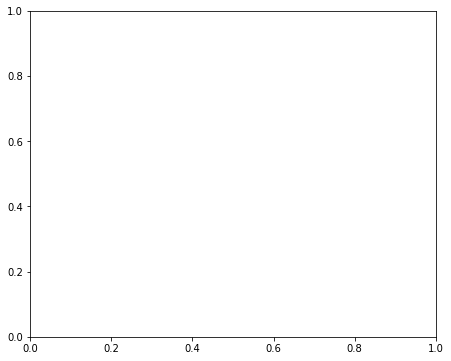

In [0]:
# Plot discriminator & generator losses to analyze the behavior of both 
# subnetworks & assess whether they converged
# Also plot the avg probabilities of the batches of real & fake examples

import itertools
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)
epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
## Plotting the outputs of the discriminator
ax = fig.add_subplots(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.setxticklabels(epocj_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

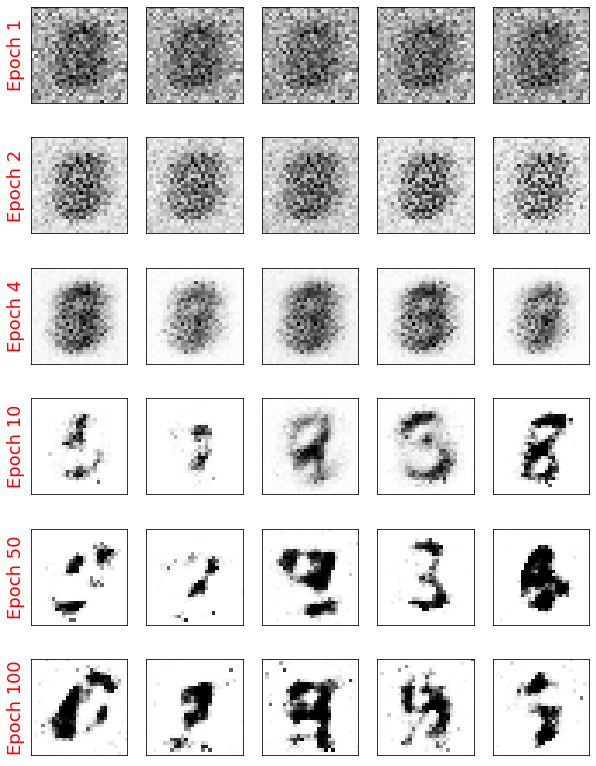

In [0]:
# Lets visualize some of the images produced by the generator for a selection of epochs
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, 'Epoch {}'.format(e),
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes)
      
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

As we can see from above figure, the generator network produced more and more realistic images as the training progressed. However, even after 100 epochs, the produced images still look very different to the handwritten digits contained in the MNIST dataset.

**Improving quality of synthesized images using CNN & WGAN(Wasserstein GAN)**

Process -
Starting from a random vector, z, the DCGAN first uses fully connected layer to project z into a new vector with a proper size so that it can be reshaped into a spatial convolutional representation(h x w x c), which is smaller than the output image size. Then, a series of convolutional layers, known as transposed convolution, are used to upsample the feature maps to the desired output image size.


**Transposed Convolution**

Used for upsampling the feature space. Assume that we've an input feature map of size n x n. Then, we apply 2D convolution operation with certain padding and stride parameters to this n x n input, resulting in an output feature m x m. Now the question lies as to how we can apply another convolution operation to obtain feature map with the initial dimension n x x from this m x m output feature map while maintaining the connectivity patterns between the input and output? Note that only the shape of n x n input matrix is recovered and not the actual matrix. It is also called as fractionally strided convolution. In deep learning literature, another term that is used to refer to transposed convolution is deconvolution, which is defined as the inverse of a convolutional operation. 

**Batch Normalization**

The main idea behind BatchNorm is normalizing the layers inputs and preventing changes in their distribution during training, which enables faster and better convergence.

Process - 
Assume that we've the net preactivation feature maps obtained after a convolutional layer in a four-dimensional tensor Z, with the shape [m x h x w x c], where m is the num of examples in the batch, h x w is the spatial dimension of the feature maps, and c is the number of channels. 

BatchNorm can be summarized in three steps - 
a. Compute the mean & std deviation of the net inputs for each mini-batch
b. Standardize the net inputs for all examples in the batch
c. Scale and shift the normalized net inputs using two learnable parameter vectors.

**Implementing the generator and discriminator**

The generator takes a vector, z, of size 20 as input, applies a fully connected (dense) layer to increase its size to 6272 and then reshapes it into a rank-3 tensor of shape 7 x 7 x 128(spatial dimension -  7 x 7, 128 channels). Then, a series of transposed convolutions upsamples the feature maps until the spatial dimension of the resulting feature maps reaches 28 x 28. The num of channels is reduced by half adter each transposed convolutional layer, except the last one, which uses only one output filter to generate a grayscale image. Each transposed convolutional layer is followed by BatchNorm and leaky ReLU activation functions, except the last one, which uses tanh activation(without BatchNorm).

The discriminator recieves images of size 28 x 28 x 1, which are paased through four convolutional layers. The first three convolutional layers reduce the spatial dimensionality by 4 while increasing the number of channels of the feature maps. Each convolutional layer is also followed by BatchNorm, leaky ReLU activation, and a dropout layer with rate=0.3. The last convolutional layer uses kernels of size 7 x 7 and a single filter to reduce the spatial dimensionality of the output to 1 x 1 x 1.

In [0]:
import tensorflow as tf
import numpy as np

def make_dcgan_generator(
    z_size=20,
    output_size=(28, 28, 1),
    n_filters=128,
    n_blocks=2):
  size_factor = 2**n_blocks
  hidden_size = (
      output_size[0]//size_factor,
      output_size[1]//size_factor)
  
  model = tf.keras.Sequential([
       tf.keras.layers.Input(shape=(z_size,)),

       tf.keras.layers.Dense(
           units=n_filters*np.prod(hidden_size),
           use_bias=False),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),

        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5),
            strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()                                                      
  ])

  nf = n_filters
  for i in range(n_blocks):
    nf = nf // 2
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=nf, kernel_size=(5, 5),
            strides=(2, 2), padding='same',
            use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

  model.add(
      tf.keras.layers.Conv2DTranspose(
          filters=output_size[2], kernel_size=(5, 5),
          strides=[1, 1], padding='same', use_bias=False,
          activation='tanh'))
  return model

def make_dcgan_discriminator(
    input_size=(28, 28, 1),
    n_filters=64,
    n_blocks=2):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=input_size),
      tf.keras.layers.Conv2D(
          filters=n_filters, kernel_size=5,
          strides=(1, 1), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU()                        
  ])

  nf = n_filters
  for i in range(n_blocks):
    nf = nf * 2
    model.add(
        tf.keras.layers.Conv2D(
            filters=nf, kernel_size=(5, 5),
            strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

  model.add(
      tf.keras.layers.Conv2D(
          filters=1, kernel_size=(7, 7),
          padding='valid'))
  model.add(tf.keras.layers.Reshape((1,)))

  return model

In [0]:
import tensorflow_datasets as tfds
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnsit = mnist_bldr.as_dataset(shuffle_files=False)
# Function to tranform the dataset to output an image tensor
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)

  image = image*2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image

In [0]:
# create a generator network
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6272)              125440    
_________________________________________________________________
batch_normalization_14 (Batc (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_15 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 128)        

In [0]:
disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 128)      

Notice that the number of parameters for BatchNorm layers is indeed four times the num of channels(4 x channels). Remember that the BatchNorm parameters mean and std dvd the (non-trainable params) for each feature value inferred from a given batch. 

Using **Earth Mover's** distance to measure dissimilarity between the distribution of real and fake examples - 

Let's assume Pr is the distribution of the real examples and Pg is the distribution of fake(generated) examples. Pr and Pg replace P and Q in the EM distance equation. Hence, the computation of the EM distance can be simplified using a theorem called Kantorovich-Rubinstein Duality.

Using Wasserstein Distance to measure loss - 

The critic(Discriminator network) returns its outputs for the batch of real image examples and the batch of synthesized examples. We use the notations D(x) and D(G(z)).

**Gradient Penalty**

Rather than clipping weight as it leads to exploding and vanishing gradients, an alternate solution was proposed by Ishaan Guljarani et al. named Gradient Penalty.

Process - 
1. For each pair of real and fake examples in a given batch, choose a random number, sampled from a uniform distribution.
2. Calculate an interpolation between the real and fake examples.
3. Compute the discriminator (critic) output for all the interpolated examples.
4. Calculate the gradients of the critic's output with respect to each interpolated example.
5. Compute the GP.


In [0]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0
tf.random.set_seed(1)
np.random.seed(1)
## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)
## Set-up the model
with tf.device(device_name):
  gen_model = make_dcgan_generator()
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_dcgan_discriminator()
  disc_model.build(input_shape=(None, np.prod(image_size)))

In [0]:
import time 
import tensorflow as tf

## Optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape=(batch_size, z_size),
      minval=-1,
      maxval=1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(
      shape=(batch_size, z_size))
  
def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images + 1) / 2.0
all_losses = []
epoch_samples = []
start_time = time.time()
for epoch in range(1, num_epochs+1):
  epoch_losses = []

  for i, (input_z, input_real) in enumerate(mnist_trainset):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      g_output = gen_model(input_z, training=True)
      d_critics_real = disc_model(input_real, training=True)
      d_critics_fake = disc_model(g_output, training=True)

      ## Compute generator's loss:
      g_loss = -tf.math.reduce_mean(d_critics_fake)

      ## Compute discriminator's loss:
      d_loss_real = -tf.math.reduce_mean(d_critics_real)
      d_loss_fake = tf.math.reduce_mean(d_critics_fake)
      d_loss = d_loss_real + d_loss_fake

      ## Gradient-penalty:
      with tf.GradientTape() as gp_tape:
        alpha = tf.random.uniform(
            shape=[d_critics_real.shape[0], 1, 1, 1],
            minval=0.0, maxval=1.0)
        interpolated = (alpha*input_real + (1-alpha)*g_output)
        gp_tape.watch(interpolated)
        d_critics_intp = disc_model(interpolated)

        grads_intp = gp_tape.gradient(
            d_critics_intp, [interpolated,]) [0]
        grads_intp_l2 = tf.sqrt(
            tf.reduce_sum(tf.square(grads_intp),
                          axis=[1, 2, 3]))
        grad_penalty = tf.reduce_mean(tf.square(
                          grads_intp_l2 - 1.0))
        d_loss = d_loss + lambda_gp * grad_penalty

        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(grads_and_vars=zip(g_grads,
                                    gen_model.trainable_variables))
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(),
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
  all_losses.append(epoch_losses)
  print(
      'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
      ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f}'
      ' D-Fake: {:6.2f}]'.format(
          epoch, (time.time() - start_time)/60,
          *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 1.40 min | Avg Losses >> G/D 207.27/-343.61 [D-Real: -226.22 D-Fake: -207.27]
Epoch 002 | ET 2.81 min | Avg Losses >> G/D 145.94/-104.06 [D-Real: -87.25 D-Fake: -145.94]
Epoch 003 | ET 4.21 min | Avg Losses >> G/D 126.60/-69.21 [D-Real: -54.23 D-Fake: -126.60]
Epoch 004 | ET 5.61 min | Avg Losses >> G/D  93.74/ 20.86 [D-Real:   1.76 D-Fake: -93.74]
Epoch 005 | ET 7.01 min | Avg Losses >> G/D  55.37/ -2.77 [D-Real:  -4.12 D-Fake: -55.37]
Epoch 006 | ET 8.41 min | Avg Losses >> G/D  68.07/-17.19 [D-Real:  30.95 D-Fake: -68.07]
Epoch 007 | ET 9.82 min | Avg Losses >> G/D  59.25/-13.99 [D-Real:  30.43 D-Fake: -59.25]
Epoch 008 | ET 11.22 min | Avg Losses >> G/D  45.04/-27.18 [D-Real:   1.74 D-Fake: -45.04]
Epoch 009 | ET 12.63 min | Avg Losses >> G/D  80.81/-20.31 [D-Real:  56.65 D-Fake: -80.81]
Epoch 010 | ET 14.04 min | Avg Losses >> G/D  64.28/-33.22 [D-Real:  24.77 D-Fake: -64.28]
Epoch 011 | ET 15.45 min | Avg Losses >> G/D 106.89/-38.76 [D-Real:  52.41 D-Fake: -106.89]

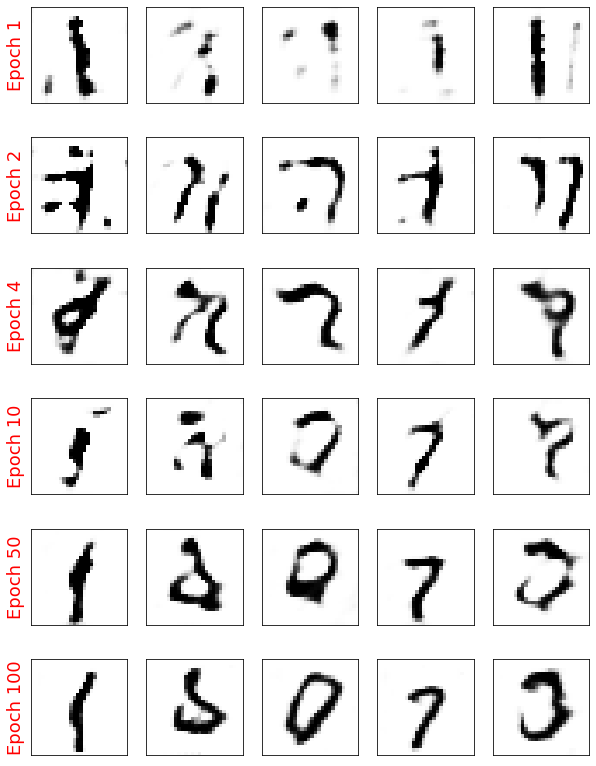

In [0]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, 'Epoch {}'.format(e),
              rotation=90, size=18, color='red',
              horizontalalignment='right',
              verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

As we can see from above that compared to vanilla GAN, the new examples shows that DCGAN(with Wasserstein and GP) can generate images of a much higher quality.